In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import time

import PulseFinderScipy as pf
import PulseQuantities as pq
import PulseClassification as pc

In [2]:
data_dir = "G:/My Drive/crystalize/data/data-202104/041421/Po_2.8g_3.0c_1.1bar_circ_60min_1747/"

In [3]:
# set plotting style
mpl.rcParams['font.size']=10
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]

# use for coloring pulses
pulse_class_colors = np.array(['blue', 'green', 'red', 'magenta', 'darkorange'])
pulse_class_labels = np.array(['Other', 'S1-like LXe', 'S1-like gas', 'S2-like', 'Merged S1/S2'])
pc_legend_handles=[]
for class_ind in range(len(pulse_class_labels)):
    pc_legend_handles.append(mpl.patches.Patch(color=pulse_class_colors[class_ind], label=str(class_ind)+": "+pulse_class_labels[class_ind]))

# ==================================================================
# define DAQ and other parameters
#wsize = 12500             # size of event window in samples. 1 sample = 2 ns.
event_window = 25.  # in us
wsize = int(500 * event_window)  # samples per waveform # 12500 for 25 us
vscale = (2000.0/16384.0) # = 0.122 mV/ADCC, vertical scale
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale

post_trigger = 0.5 # Was 0.2 for data before 11/22/19
trigger_time_us = event_window*(1-post_trigger)
trigger_time = int(trigger_time_us/tscale)

n_sipms = 8
n_channels = n_sipms+1 # includes sum

# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)

# sphe sizes in mV*sample
chA_spe_size = 29.02
chB_spe_size = 30.61
chC_spe_size = 28.87
chD_spe_size = 28.86*1.25 # scale factor (0.7-1.4) empirical as of Dec 9, 2020
chE_spe_size = 30.4
chF_spe_size = 30.44
chG_spe_size = 30.84
chH_spe_size = 30.3*1.8 # scale factor (1.6-2.2) empirical as of Dec 9, 2020
spe_sizes = [chA_spe_size, chB_spe_size, chC_spe_size, chD_spe_size, chE_spe_size, chF_spe_size, chG_spe_size, chH_spe_size]

In [6]:
listrq = np.load(data_dir+'rq.npz')

n_events = listrq['n_events'][()]
n_pulses = listrq['n_pulses']
n_s1 = listrq['n_s1']
n_s2 = listrq['n_s2']
s1_before_s2 = listrq['s1_before_s2']
p_area = listrq['p_area']
p_class = listrq['p_class']
drift_Time = listrq['drift_Time']
p_max_height = listrq['p_max_height']
p_min_height = listrq['p_min_height']
p_width = listrq['p_width']
p_afs_2l = listrq['p_afs_2l']
p_afs_50 = listrq['p_afs_50']
p_area_ch = listrq['p_area_ch']
p_area_ch_frac = listrq['p_area_ch_frac']
p_area_top = listrq['p_area_top']
p_area_bottom = listrq['p_area_bottom']
p_tba = listrq['p_tba']
sum_s1_area = listrq['sum_s1_area']
sum_s2_area = listrq['sum_s2_area']

center_top_x = listrq['center_top_x']
center_top_y = listrq['center_top_y']
center_bot_x = listrq['center_bot_x']
center_bot_y = listrq['center_bot_y']

listrq.close()

In [7]:
n_golden = int(np.sum(drift_Time>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden,n_golden*100./n_events))

p_t_rise = tscale*(p_afs_50-p_afs_2l)

# Define some standard cuts for plotting
cut_dict = {}
cut_dict['ValidPulse'] = p_area > 0
cut_dict['PulseClass0'] = p_class == 0
cut_dict['S1'] = (p_class == 1) + (p_class == 2)
cut_dict['S2'] = (p_class == 3) + (p_class == 4)
cut_dict['Co_peak'] = (p_area>30)*(p_area<60)
SS_cut = drift_Time > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=True # One entry per pulse
save_S1S2_plots=True # One entry per S1 (S2) pulse
save_event_plots=True # One entry per event
pulse_cut_name = 'ValidPulse'#'Co_peak'
pulse_cut = cut_dict[pulse_cut_name]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut),np.sum(pulse_cut)*100./np.size(p_area)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

s1_cut = pulse_cut*cut_dict['S1']
cleanS1Area = p_area[s1_cut].flatten()
cleanS1RiseTime = p_t_rise[s1_cut].flatten()
cleanS1AreaChFrac = p_area_ch_frac[s1_cut]
cleanS1TBA = p_tba[s1_cut].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut),np.sum(s1_cut)*100./np.size(p_area)))

s2_cut = pulse_cut*cut_dict['S2']
cleanS2Area = p_area[s2_cut].flatten()
cleanS2RiseTime = p_t_rise[s2_cut].flatten()
cleanS2AreaChFrac = p_area_ch_frac[s2_cut]
cleanS2TBA = p_tba[s2_cut].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut),np.sum(s2_cut)*100./np.size(p_area)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany = n_pulses < 1000 # How many pulses you do want
nArea = p_area[howMany,:]
nMax = p_max_height[howMany,:]
nmin = p_min_height[howMany,:]
nWidth = p_width[howMany,:]

na2l = p_afs_2l[howMany]
na50 = p_afs_50[howMany]


# Event level quantities 
event_cut_dict = {}
event_cut_dict["SS"] = drift_Time > 0 
event_cut_dict["MS"] = (n_s1 == 1)*(n_s2 > 1)*s1_before_s2
event_cut_dict["Po"] = (drift_Time>0)*np.any((p_tba<-0.25)*(p_tba>-0.72)*(p_area>1400)*(p_area<3200), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["lg_S1"] = (drift_Time>0)*np.any((p_area>1000.)*cut_dict["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict["ht"] = (drift_Time>0)*np.any(p_max_height>50, axis=1)
event_cut_dict["area"] = (sum_s1_area>10**3.0)*(sum_s1_area<10**3.5)*(sum_s2_area<10**5.1)*(sum_s2_area>10**4.6)
event_cut_dict["orange"] = np.any((p_tba<-0.3)*(p_tba>-0.75)*(p_t_rise>0.6)*(p_t_rise<1.7), axis=1)
event_cut_dict["Po_left"] = np.any((p_tba<-0.76)*(p_tba>-1.)*(p_area>2000)*(p_area<3000), axis=1)

event_cut_name = "SS"#"Po_left"#"lg_S1"
event_cut = event_cut_dict[event_cut_name] 
cleanSumS1 = sum_s1_area[event_cut]
cleanSumS2 = sum_s2_area[event_cut]
cleanDT = drift_Time[event_cut]

four_drift_time = np.transpose([drift_Time, drift_Time,drift_Time,drift_Time])
clean_drift_time_four = four_drift_time[event_cut]
clean_center_top_x = center_top_x[event_cut]
clean_center_top_y = center_top_y[event_cut]
clean_center_bot_x = center_bot_x[event_cut]
clean_center_bot_y = center_bot_y[event_cut]

cleanArea = p_area[pulse_cut]
cleanMax = p_max_height[pulse_cut]
cleanMin = p_min_height[pulse_cut]
cleanWidth = p_width[pulse_cut]
cleanPulseClass = p_class[pulse_cut]

cleanAFS2l = p_afs_2l[pulse_cut]
cleanAFS50 = p_afs_50[pulse_cut]
cleanRiseTime = p_t_rise[pulse_cut]

cleanAreaCh = p_area_ch[pulse_cut] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac = p_area_ch_frac[pulse_cut]
cleanAreaTop = p_area_top[pulse_cut]
cleanAreaBottom = p_area_bottom[pulse_cut]
cleanTBA = p_tba[pulse_cut]
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

print("number of events found passing cut "+event_cut_name+" = {0:d} ({1:g}%)".format(np.sum(event_cut),np.sum(event_cut)*100./n_events))


number of golden events found = 13423 (9.90043%)
number of pulses found passing cut ValidPulse = 178983 (33.0032% of pulses found)
number of S1 pulses found = 80863 (14.9106% of pulses found)
number of S2 pulses found = 98120 (18.0926% of pulses found)
number of events found passing cut SS = 13423 (9.90043%)


**Plots of all pulses combined (after cuts)**

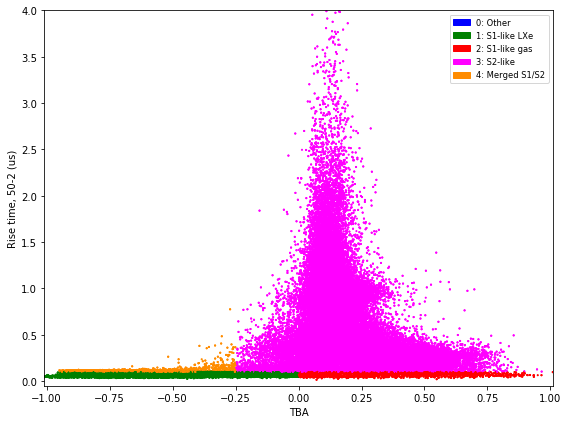

In [8]:
pl.figure()
pl.scatter(cleanTBA, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(-0.05,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_TBA_"+pulse_cut_name+".png")

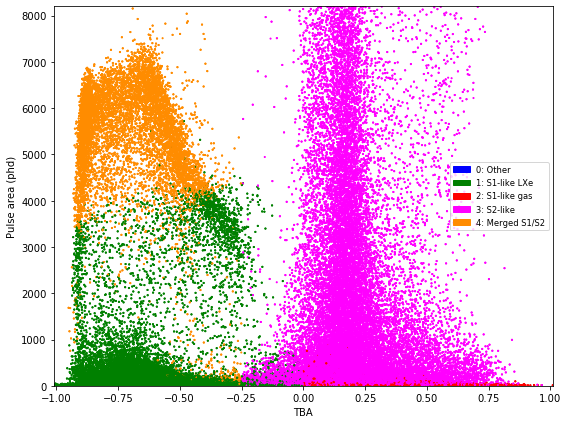

In [9]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(0, 8200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

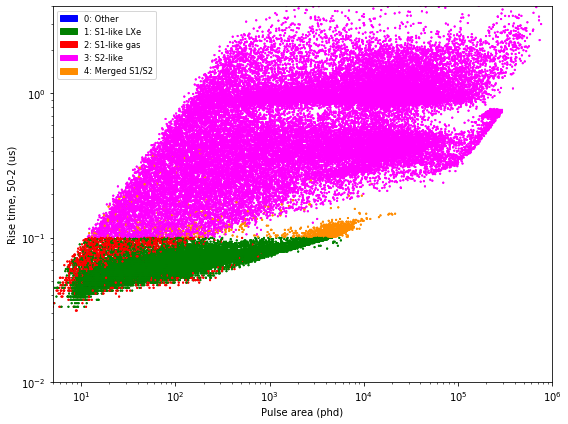

In [10]:
pl.figure()
pl.xscale("log")
pl.yscale("log")
pl.scatter(cleanArea, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(5,10**6)
pl.ylim(0.01,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("Pulse area (phd)")
pl.legend(handles=pc_legend_handles)
#pl.xlim(0.7*min(p_area.flatten()), 1.5*max(p_area.flatten()))
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_PulseArea_"+pulse_cut_name+".png")

In [13]:
from sklearn.mixture import GaussianMixture

# Define the 2D array of data to cluster
X_cluster = np.array([np.log10(cleanRiseTime), np.log10(cleanArea), cleanTBA]).T # transpose for correct structure
gm = GaussianMixture(n_components=4, random_state=0).fit(X_cluster)
cluster_output = gm.predict(X_cluster)

Text(0.5, 0, 'TBA')

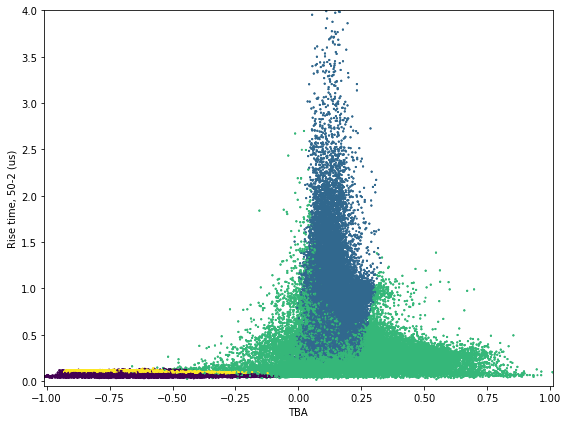

In [14]:
pl.figure()
pl.scatter(cleanTBA, cleanRiseTime, s = 1.2, c = cluster_output)
pl.xlim(-1.01,1.01)
pl.ylim(-0.05,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("TBA")
#pl.legend(handles=pc_legend_handles)
#if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_TBA_"+pulse_cut_name+".png")

Text(0.5, 0, 'TBA')

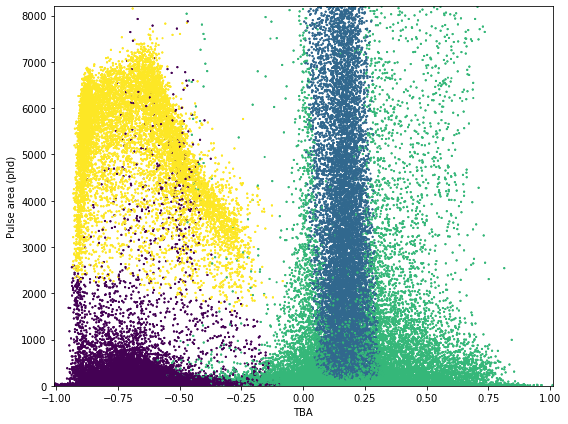

In [15]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2, c = cluster_output)
pl.xlim(-1.01,1.01)
pl.ylim(0, 8200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
#pl.legend(handles=pc_legend_handles)
#if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

Text(0.5, 0, 'Pulse area (phd)')

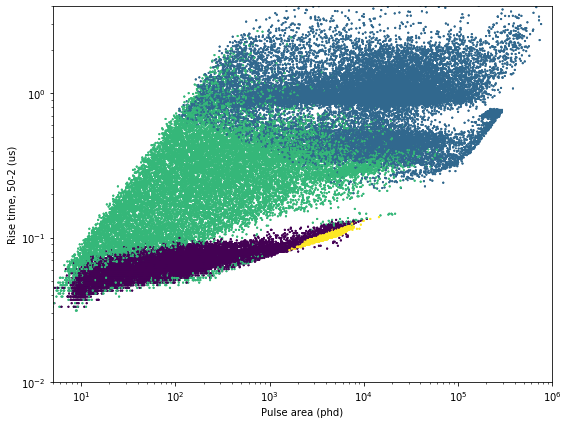

In [16]:
pl.figure()
pl.xscale("log")
pl.yscale("log")
pl.scatter(cleanArea, cleanRiseTime, s = 1.2, c = cluster_output)
pl.xlim(5,10**6)
pl.ylim(0.01,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("Pulse area (phd)")
#pl.legend(handles=pc_legend_handles)
#if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_PulseArea_"+pulse_cut_name+".png")